In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import symbols, Eq, solve, lambdify, Float
from tabulate import tabulate

In [18]:
def ajuste_polinomial_minimos_quadrados(x_vals, y_vals, grau=1):
    x = symbols('x')
    n = len(x_vals)

    A = []
    for i in range(grau + 1):
        linha = [sum(xi**(i + j) for xi in x_vals) for j in range(grau + 1)]
        A.append(linha)

    B = [sum(y_vals[k] * x_vals[k]**i for k in range(n)) for i in range(grau + 1)]

    a = sp.symbols(f'a0:{grau+1}')
    sistema = [Eq(sum(A[i][j]*a[j] for j in range(grau + 1)), B[i]) for i in range(grau + 1)]
    solucao = solve(sistema, a)

    coeficientes = [Float(solucao[a[i]].evalf(), 4) for i in range(grau + 1)]
    polinomio = sum(coeficientes[i] * x**i for i in range(grau + 1))
    f_ajuste = lambdify(x, polinomio, 'numpy')
    tabela = [(round(xi, 4), round(f_ajuste(xi), 4)) for xi in x_vals]

    return polinomio, tabela, f_ajuste

def ajuste_exponencial_log(x_vals, y_vals):
    x = symbols('x')
    # Linearização
    y_ln = [np.log(yi) for yi in y_vals]
    polinomio_ln, _, f_ln = ajuste_polinomial_minimos_quadrados(x_vals, y_ln, grau=1)

    a1 = polinomio_ln.coeff(x)
    ln_a0 = polinomio_ln.coeff(x, 0)
    a0 = sp.exp(ln_a0)

    func_exp = a0 * sp.exp(a1 * x)
    f_ajuste = lambdify(x, func_exp, 'numpy')
    tabela = [(round(xi, 4), round(f_ajuste(xi), 4)) for xi in x_vals]

    return func_exp, tabela, f_ajuste

In [19]:
def correlacao_pearson(x_vals, y_vals):
    n = len(x_vals)
    soma_x = sum(x_vals)
    soma_y = sum(y_vals)
    soma_xy = sum(x * y for x, y in zip(x_vals, y_vals))
    soma_x2 = sum(x ** 2 for x in x_vals)
    soma_y2 = sum(y ** 2 for y in y_vals)

    numerador = n * soma_xy - soma_x * soma_y
    denominador = np.sqrt((n * soma_x2 - soma_x ** 2) * (n * soma_y2 - soma_y ** 2))

    if denominador == 0:
        return 0
    return numerador / denominador

In [20]:
def calcular_rmse(y_real, y_aprox):
    return np.sqrt(np.mean((np.array(y_real) - np.array(y_aprox)) ** 2))

Ajuste de Curvas - Mínimos Quadrados

Função ajustada (Exponencial (via ln)):
       -1.248⋅x
383.6⋅ℯ        

Tabela de pontos:
+------+--------------+
|    x |   y ajustado |
+======+==============+
| 1    |     110.123  |
+------+--------------+
| 1.25 |      80.6082 |
+------+--------------+
| 1.5  |      59.0037 |
+------+--------------+
| 1.75 |      43.1896 |
+------+--------------+
| 2    |      31.614  |
+------+--------------+
y(3.0) ≈ 9.0757
Soluções reais encontradas para x:
x1 ≈ 2.593

Coeficiente de correlação de Pearson (final): r = -0.9948


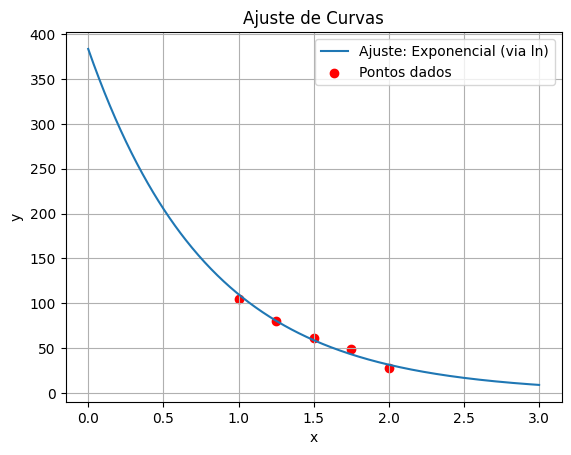

In [22]:
# ===== INÍCIO DO SCRIPT =====
print("Ajuste de Curvas - Mínimos Quadrados")

x_vals = [1, 1.25, 1.5, 1.75, 2]
y_vals = [105, 80.2, 61.7, 48.8, 28.3]
n = len(x_vals)

modo = input("\nModo de ajuste? (manual/auto/exponencial): ").strip().lower()

if modo == 'exponencial':
    polinomio, tabela, f_ajuste = ajuste_exponencial_log(x_vals, y_vals)
    tipo_ajuste = "Exponencial (via ln)"
    grau = None
else:
    if modo == 'manual':
        grau = int(input("Digite o grau do polinômio de ajuste: "))
    else:
        print("\nProcurando melhor grau de ajuste...")
        menor_rmse = float('inf')
        melhor_grau = 1
        analise_ajustes = []

        for grau_teste in range(1, min(n, 5)):
            polinomio_teste, _, f_teste = ajuste_polinomial_minimos_quadrados(x_vals, y_vals, grau_teste)
            y_aprox = f_teste(np.array(x_vals))
            erro = calcular_rmse(y_vals, y_aprox)
            correlacao = correlacao_pearson(y_vals, y_aprox)
            polinomio_str = str(polinomio_teste.evalf(n=5)).replace("**", "^")

            analise_ajustes.append((grau_teste, round(erro, 4), round(correlacao, 4), polinomio_str))

            if erro < menor_rmse:
                menor_rmse = erro
                melhor_grau = grau_teste

        print("\nTabela de análise por grau:")
        print(tabulate(analise_ajustes, headers=["Grau", "RMSE", "Correlação", "Polinômio"], tablefmt="grid"))
        grau = melhor_grau
        print(f"\nGrau escolhido automaticamente: {grau}")

    polinomio, tabela, f_ajuste = ajuste_polinomial_minimos_quadrados(x_vals, y_vals, grau)
    tipo_ajuste = f"Polinomial grau {grau}"

# Exibe o polinômio/função com coeficientes arredondados
x = sp.Symbol('x')

if modo == 'exponencial':
    func_mostrar = polinomio.evalf(4)
else:
    coef_rounded = [sp.N(c, 4) for c in polinomio.as_poly().all_coeffs()]
    coef_rounded = list(reversed(coef_rounded))
    func_mostrar = sum(coef_rounded[i] * x**i for i in range(len(coef_rounded)))

print(f"\nFunção ajustada ({tipo_ajuste}):")
print(sp.pretty(func_mostrar, use_unicode=True))

# Exibe a tabela de valores ajustados
print("\nTabela de pontos:")
print(tabulate(tabela, headers=["x", "y ajustado"], tablefmt="grid"))

# Estimar y dado x
x_estimado = float(input("\nDigite um valor de x para estimar y: "))
y_estimado = f_ajuste(x_estimado)
print(f"y({x_estimado}) ≈ {y_estimado:.4f}")

# Estimar x dado y
y_alvo = float(input("\nDigite um valor de y para estimar x: "))
equacao = Eq(polinomio, y_alvo)
solucoes_x = solve(equacao, x)
solucoes_reais = [sol.evalf(4) for sol in solucoes_x if sol.is_real]

if solucoes_reais:
    print("Soluções reais encontradas para x:")
    for i, sol in enumerate(solucoes_reais):
        print(f"x{i+1} ≈ {sol}")
else:
    print("Nenhuma solução real encontrada para x.")

# Correlação de Pearson
pearson_r = correlacao_pearson(x_vals, y_vals)
print(f"\nCoeficiente de correlação de Pearson (final): r = {pearson_r:.4f}")

# Gráfico
x_plot = np.linspace(min(x_vals) - 1, max(x_vals) + 1, 500)
y_plot = f_ajuste(x_plot)

plt.plot(x_plot, y_plot, label=f'Ajuste: {tipo_ajuste}')
plt.scatter(x_vals, y_vals, color='red', label='Pontos dados')
plt.title('Ajuste de Curvas')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()